In [9]:
import scanpy
import numpy as np
import pandas as pd
import seaborn as sns
import gseapy as gp
import matplotlib.pyplot as plt

In [3]:
sns.set(font_scale=1.2)

In [22]:
granger_scores = scanpy.read_h5ad('results/granger_causality.h5ad')
cluster_labels = pd.read_csv('results/proliferation_2_clusters_top_hvgs.csv', index_col='Unnamed: 0').set_index('mouse')

In [5]:
gene_clusters = pd.read_csv('results/proliferation_2_clusters_top_hvgs.csv', index_col=0)
gene_clusters = gene_clusters.set_index('mouse')

In [6]:
granger_df = granger_scores.to_df()

In [7]:
# sort rows and columns by gene cluster
granger_df = granger_df.loc[gene_clusters.loc[granger_scores.obs_names].sort_values('cluster').index][gene_clusters.loc[granger_scores.var_names].sort_values('cluster').index]

In [10]:
lut = {i: plt.get_cmap("tab10")(i) for i in range(2)}
row_colors = (
        gene_clusters.loc[granger_scores.obs_names].sort_values('cluster')['cluster'].map(lut).rename("Cluster Order")
)

col_colors = (
        gene_clusters.loc[granger_scores.var_names].sort_values('cluster')['cluster'].map(lut).rename("Cluster Order")
)

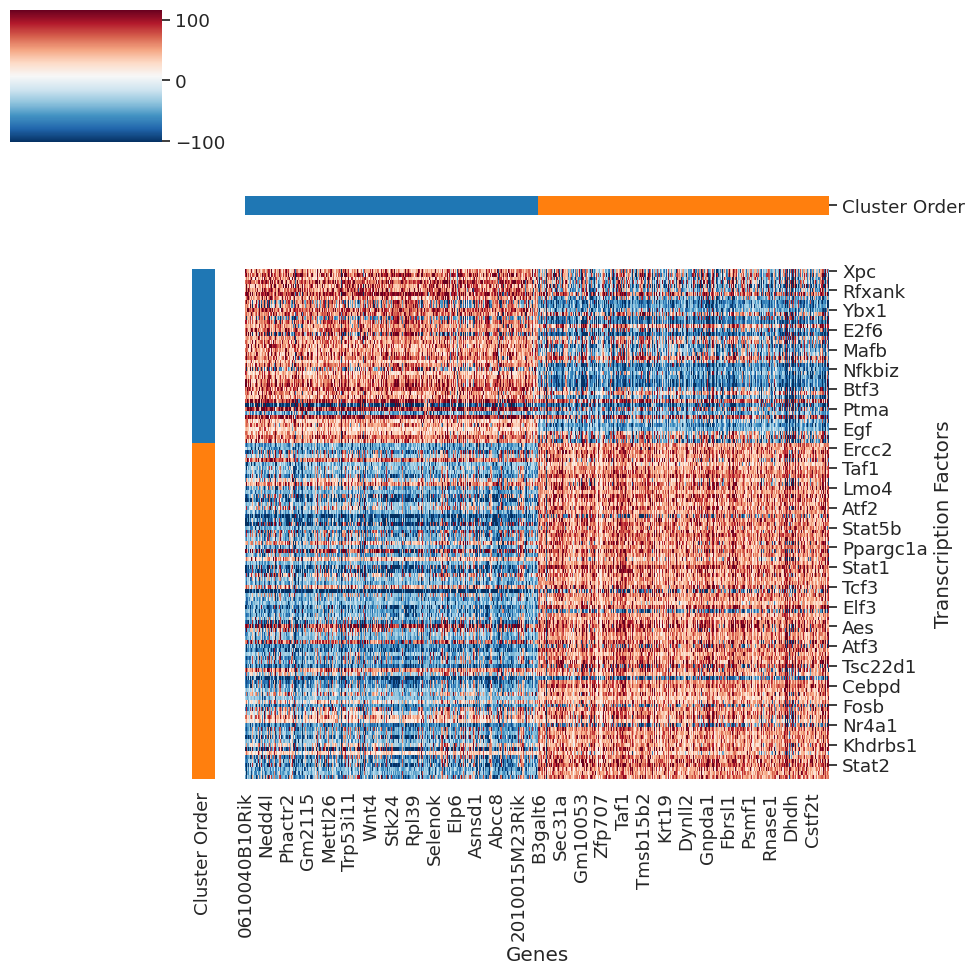

In [11]:
g = sns.clustermap(granger_df, cmap='RdBu_r',
                   vmax=np.percentile(granger_df, 95), vmin=np.percentile(granger_df, 5),
                   row_cluster=False,
                   col_cluster=False,
                   row_colors=row_colors,
                   col_colors=col_colors)

ax = g.ax_heatmap
ax.set_ylabel('Transcription Factors')
ax.set_xlabel('Genes')
plt.tight_layout()
plt.savefig('figures/signed_granger_scores.png', dpi=200)

**1. Found the top 100 transcription factors that had the most regulatory effect within their respective trajectory.**

In [12]:
tf_strength = pd.concat((np.abs(granger_df).sum(axis=1).sort_values(ascending=False), gene_clusters), axis=1).dropna()
tf_strength.columns = ['TF_strength'] + list(tf_strength.columns[1:])
tf_strength.to_csv('results/proliferation_all_TF_strength.csv')

In [13]:
trrust = pd.read_csv('../data/trrust_rawdata.human.tsv', sep='\t', header=None)
trrust = trrust[trrust[0].isin(list(map(lambda x: x.upper(), granger_scores.var_names))) & \
trrust[1].isin(list(map(lambda x: x.upper(), granger_scores.var_names)))]
trrust[0] = list(map(lambda x: x.capitalize(), trrust[0]))
trrust[1] = list(map(lambda x: x.capitalize(), trrust[1]))

In [14]:
# add Granger score to each TF and target
granger_scores = []
for row in trrust.iterrows():
    granger_scores.append(granger_df.loc[row[1][0]][row[1][1]])
    
trrust['granger_scores'] = granger_scores

In [15]:
trrust.to_csv('results/proliferation_all_hv_tf_target_relationships_with_granger.csv')

In [28]:
# get TFs in top 100
trrust_top_tfs = trrust[trrust[0].isin(tf_strength[:100].index)]

In [29]:
# add Granger score to each TF and target (top 100 TFs only)
scores = []
for row in trrust_top_tfs.iterrows():
    scores.append(granger_df.loc[row[1][0]][row[1][1]])
    
trrust_top_tfs['granger_scores'] = scores

/tmp/ipykernel_2323357/3935548834.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trrust_top_tfs['granger_scores'] = scores


In [30]:
# subset to only those with strong relationship
trrust_top_tfs = trrust_top_tfs[(trrust_top_tfs['granger_scores'] > 25) | (trrust_top_tfs['granger_scores'] < -25)]
trrust_top_tfs = trrust_top_tfs[[0,1,'granger_scores']].drop_duplicates()

In [31]:
trrust_top_tfs['activation'] = trrust_top_tfs['granger_scores'] > 0

In [36]:
ids = []
for i,row in enumerate(trrust_top_tfs.iterrows()):
    tf = row[1][0]
    target = row[1][1]
    if ((cluster_labels.loc[tf]['cluster'] == 0) & (cluster_labels.loc[target]['cluster'] == 0)):
        ids.append(True)
    else:
        ids.append(False)
trrust_top_tfs['both_increasing'] = ids

In [46]:
trrust_top_tfs.to_csv('results/proliferation_top_100_TF_strong_relationships.csv')

## Subset to only cluster 1

In [44]:
trrust_top_tfs.query('both_increasing').to_csv('results/proliferation_increasing_hv_tf_target_relationships_with_granger.csv')

## GSEA on genes in subnetwork

In [112]:
subnetwork_genes = np.unique(trrust_top_tfs.iloc[ids][[0, 1]].values.flatten())

In [119]:
enr = gp.enrichr(gene_list=list(subnetwork_genes), # or "./tests/data/gene_list.txt",
                         gene_sets=['BioPlanet_2019', 'Panther_2016', 'KEGG_2019_Human', 'Reactome_2022', 'GO_Biological_Process_2023'],
                         organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                         outdir=None, # don't write to disk,
                         cutoff = 1
                        )
res = enr.results[enr.results['Adjusted P-value'] < 0.05]
res['Overlap'] = res['Overlap'].str.replace('/', ' of ')
res.to_csv(f'results/CCK_subnetwork_GSEA.csv')

/tmp/ipykernel_111293/3663742404.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res['Overlap'] = res['Overlap'].str.replace('/', ' of ')
